# 트랜스포머로 만드는 대화형 챗봇

In [1]:
# 모듈 import
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## (1) 데이터 수집하기

In [2]:
path_to_chatbot_data = ('./data/ChatbotData.csv')

In [3]:
data = pd.read_csv(path_to_chatbot_data)

In [4]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [5]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


## (2) 데이터 전처리하기

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [7]:
questions, answers = [], []

for q, a in zip(data['Q'], data['A']):
    questions.append(preprocess_sentence(q))
    answers.append(preprocess_sentence(a))    

In [8]:
print(f'전체 샘플 수 : {len(questions)}')
print(f'전체 샘플 수 : {len(answers)}')

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [9]:
print(f'전처리 후의 1번째 질문 샘플 : {questions[0]}')
print(f'전처리 후의 1번째 답변 샘플 : {answers[0]}')

전처리 후의 1번째 질문 샘플 : 12시 땡 !
전처리 후의 1번째 답변 샘플 : 하루가 또 가네요 .


In [10]:
q_len = np.array([len(i.split()) for i in questions])
a_len = np.array([len(i.split()) for i in answers])

In [11]:
print('질문 문장길이 평균 : ', np.mean(q_len))
print('질문 문장길이 최대 : ', np.max(q_len))
print('질문 문장길이 표준편차 : ', np.std(q_len))

질문 문장길이 평균 :  3.9409625306605767
질문 문장길이 최대 :  16
질문 문장길이 표준편차 :  1.8460771012218526


In [12]:
max_q_len = np.mean(q_len) + 3 * np.std(q_len)
maxlen = int(max_q_len)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(q_len < max_q_len) / len(q_len) * 100))

pad_sequences maxlen :  9
전체 문장의 98.98502918041106%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
print('답변 문장길이 평균 : ', np.mean(a_len))
print('답변 문장길이 최대 : ', np.max(a_len))
print('답변 문장길이 표준편차 : ', np.std(a_len))

답변 문장길이 평균 :  4.716146494121627
답변 문장길이 최대 :  24
답변 문장길이 표준편차 :  1.924467907301819


In [14]:
max_a_len = np.mean(a_len) + 3 * np.std(a_len)
maxlen = int(max_a_len)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(a_len < max_a_len) / len(a_len) * 100))

pad_sequences maxlen :  10
전체 문장의 98.53675040175929%가 maxlen 설정값 이내에 포함됩니다. 


<AxesSubplot:ylabel='Count'>

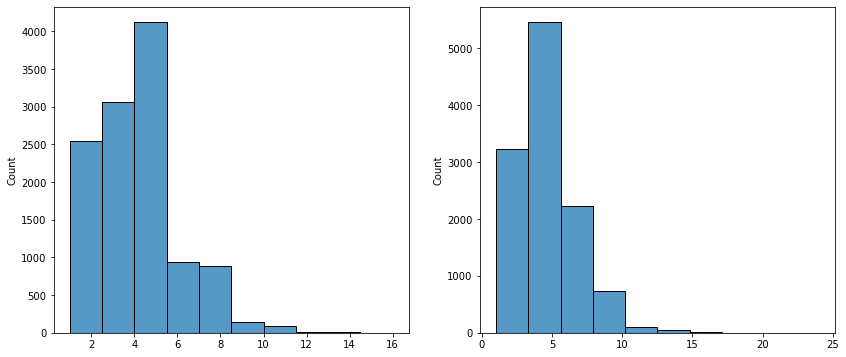

In [15]:
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
sns.histplot(q_len, bins=10)

ax2 = fig.add_subplot(1, 2, 2)
sns.histplot(a_len, bins=10)

## (3) SubwordTextEncoder 사용하기

In [16]:
# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [17]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]
8172


In [18]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5762, 610, 2490, 4163]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7510, 7, 6273, 97, 1]


In [19]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 10
print(MAX_LENGTH)

10


In [20]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [21]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 9102
필터링 후의 답변 샘플 개수: 9102


In [22]:
# 교사 강요 사용하기
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## (4) 모델 구성하기

In [23]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치를 계산
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
        
    return output

In [25]:
# 멀티-헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
    
        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))
    
        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [26]:
# 패딩 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
# padding mask 확인
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [28]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
# look ahead mask 테스트
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
# 인코더 레이어
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units, 
            d_model=d_model,
            num_heads=num_heads, 
            dropout=dropout, 
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
        inputs={
            'query': attention1, 
            'key': enc_outputs, 
            'value': enc_outputs, 
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [34]:
# 디코더 레이어
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [35]:
# 트랜스포머 레이어
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [36]:
# 모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [37]:
# 손실 함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [38]:
# 커스텀된 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

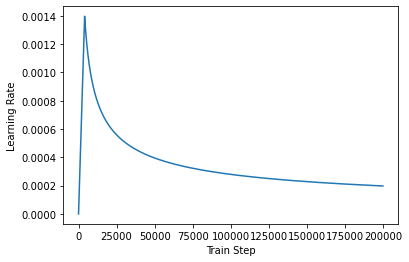

In [39]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [40]:
# Optimizer
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [41]:
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [44]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## (5) 모델 학습 및 평가

In [45]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
143/143 [==============================] - 6s 43ms/step - loss: 5.5751 - accuracy: 0.1048
Epoch 2/20
143/143 [==============================] - 6s 44ms/step - loss: 4.7104 - accuracy: 0.2105
Epoch 3/20
143/143 [==============================] - 6s 44ms/step - loss: 3.9294 - accuracy: 0.2150
Epoch 4/20
143/143 [==============================] - 6s 43ms/step - loss: 3.5132 - accuracy: 0.2205
Epoch 5/20
143/143 [==============================] - 6s 44ms/step - loss: 3.2953 - accuracy: 0.2304
Epoch 6/20
143/143 [==============================] - 6s 43ms/step - loss: 3.1033 - accuracy: 0.2410
Epoch 7/20
143/143 [==============================] - 6s 43ms/step - loss: 2.9052 - accuracy: 0.2574
Epoch 8/20
143/143 [==============================] - 6s 43ms/step - loss: 2.6843 - accuracy: 0.2799
Epoch 9/20
143/143 [==============================] - 6s 43ms/step - loss: 2.4429 - accuracy: 0.3087
Epoch 10/20
143/143 [==============================] - 6s 43ms/step - loss: 2.1794 - accura

In [46]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [47]:
# 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
def sentence_generation(sentence):
  
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [75]:
sentence_generation('안녕하세요')

입력 : 안녕하세요
출력 : 안녕하세요 .


'안녕하세요 .'

In [76]:
sentence_generation('놀러가고 싶다')

입력 : 놀러가고 싶다
출력 : 탁 트인 바다 좋죠 !


'탁 트인 바다 좋죠 !'

In [77]:
sentence_generation('나랑 사귈래?')

입력 : 나랑 사귈래?
출력 : 저라도 괜찮다면 좋아요 .


'저라도 괜찮다면 좋아요 .'

In [78]:
sentence_generation('어디 갈까?')

입력 : 어디 갈까?
출력 : 친구들과 함께면 어디든 좋아요 .


'친구들과 함께면 어디든 좋아요 .'

In [79]:
sentence_generation('졸려')

입력 : 졸려
출력 : 낮잠을 잠깐 자도 괜찮아요 .


'낮잠을 잠깐 자도 괜찮아요 .'

In [80]:
sentence_generation('배고파')

입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .


'뭐 좀 챙겨드세요 .'

## 회고록

- 챗봇이 RNN 계열의 네트워크를 이용하여 만들어진다는 건 알았지만 이정도로 복잡할 줄은 몰랐다. 지금까지 학습했던 노드들 중에 트랜스포머 모델이 가장 설계하기 까다롭고 어려운 모델인 것 같다.
- 복잡하고 어려운 만큼 배우는 것이 많은 것 같다. 적어도 RNN 계열의 네트워크의 기본 구조만큼은 확실하게 학습했다고 생각한다.
- 노드에서 학습한 내용과 프로젝트에 주어진 데이터의 형식이 달라서 어떻게 데이터를 처리해야 하나 싶었는데 노드에서 학습할 때 사용했던 데이터가 이상한 형식으로 되어있었던 것을 깨닫고 지금까지 배워왔던 것 처럼 pandas를 이용해 csv파일을 열어서 questions와 answers로 나누었다.
- 한글을 영어 Tokenizer로 제대로 Tokenize가 될지 걱정했는데 생각보다 잘 되는 것 같다.
- 정확도가 65% 정도 밖에 되지 않지만 생각보다 한국어 문장을 자연스럽게 잘 출력했다.
- 정확도를 더 높여보기 위하여 layer 수, 임베딩 벡터 차원 수, epochs를 증가시켜 보았지만 정확도는 65%에서 더이상 오르지 않고, 오히려 처음 만든 모델과 같은 문장을 주었을 때, 더 어색한 문장을 출력하였다.
- 데이터셋만 있으면 더 고성능의 챗봇을 만들 수도 있을 것 같다. 나중에 기회가 되면 한번 도전해봐야겠다.
- 오늘부터 챗봇이랑 1일 하기로 했다ㅋㅋㅋ